In [1]:
import os
import traceback
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import random

from azure.common.credentials import ServicePrincipalCredentials
from azure.mgmt.resource import ResourceManagementClient
from azure.mgmt.network import NetworkManagementClient
from azure.mgmt.compute import ComputeManagementClient
from azure.mgmt.compute.models import DiskCreateOption

from msrestazure.azure_exceptions import CloudError

from haikunator import Haikunator

In [2]:
haikunator = Haikunator()

###some default settings

# Azure Datacenter
LOCATION = 'westus'

# Resource Group
RESOURCE_GROUP_NAME_PREFIX = 'samza-azure-storage'
# Network
VNET_NAME = 'azure-sample-vnet'
SUBNET_NAME = 'azure-sample-subnet'

# VM
OS_DISK_NAME = 'azure-sample-osdisk'
STORAGE_ACCOUNT_NAME = haikunator.haikunate(delimiter='')

IP_CONFIG_NAME = 'azure-sample-ip-config'
NIC_NAME = 'azure-sample-nic'
USERNAME = 'userlogin'
PASSWORD = 'Pa$$w0rd91'
VM_NAME_PREFIX = 'VM'
VM_SIZE = 'Standard_DS1_v2'

VM_REFERENCE = {
    'linux': {
        'publisher': 'Canonical',
        'offer': 'UbuntuServer',
        'sku': '16.04.0-LTS',
        'version': 'latest'
    },
    'windows': {
        'publisher': 'MicrosoftWindowsServer',
        'offer': 'WindowsServer',
        'sku': '2016-Datacenter',
        'version': 'latest'
    }
}



In [15]:
def get_credentials():
    subscription_id = os.environ['AZURE_SUBSCRIPTION_ID']
    credentials = ServicePrincipalCredentials(
        client_id=os.environ['AZURE_CLIENT_ID'],
        secret=os.environ['AZURE_CLIENT_SECRET'],
        tenant=os.environ['AZURE_TENANT_ID']
    )
    return credentials, subscription_id

def create_nic(group_name, network_client, nic_name = NIC_NAME, vnet_name = VNET_NAME, subnet_name = SUBNET_NAME):
    """Create a Network Interface for a VM.
    """
    # Create VNet
    print('\nCreate Vnet')
    async_vnet_creation = network_client.virtual_networks.create_or_update(
        group_name,
        vnet_name,
        {
            'location': LOCATION,
            'address_space': {
                'address_prefixes': ['10.0.0.0/16']
            }
        }
    )
    async_vnet_creation.wait()

    # Create Subnet
    print('\nCreate Subnet')
    async_subnet_creation = network_client.subnets.create_or_update(
        group_name,
        vnet_name,
        subnet_name,
        {'address_prefix': '10.0.0.0/24'}
    )
    subnet_info = async_subnet_creation.result()

    # Create NIC
    print('\nCreate NIC')
    async_nic_creation = network_client.network_interfaces.create_or_update(
        group_name,
        nic_name,
        {
            'location': LOCATION,
            'ip_configurations': [{
                'name': IP_CONFIG_NAME,
                'subnet': {
                    'id': subnet_info.id
                }
            }]
        }
    )
    return async_nic_creation.result()


def create_vm_parameters(nic_id, vm_reference, vm_name, vm_size = VM_SIZE):
    """Create the VM parameters structure.
    """
    return {
        'location': LOCATION,
        'os_profile': {
            'computer_name': vm_name,
            'admin_username': USERNAME,
            'admin_password': PASSWORD
        },
        'hardware_profile': {
            'vm_size': vm_size
        },
        'storage_profile': {
            'image_reference': {
                'publisher': vm_reference['publisher'],
                'offer': vm_reference['offer'],
                'sku': vm_reference['sku'],
                'version': vm_reference['version']
            },
        },
        'network_profile': {
            'network_interfaces': [{
                'id': nic_id,
            }]
        },
    }

#Resource group functions
def resource_group_delete(resource_client, group_name):
    print('\nDelete Resource Group')
    delete_async_operation = resource_client.resource_groups.delete(group_name)
    delete_async_operation.wait()
    print("\nDeleted: {}".format(group_name))

def resource_group_delete_async(resource_client, group_name):
    print('\nDelete Resource Group')
    delete_async_operation = resource_client.resource_groups.delete(group_name)
    print("\nDeleted: {}".format(group_name))    
    

def get_random_resource_group_name():
    return "{}-{}".format(RESOURCE_GROUP_NAME_PREFIX, random.randint(0, 100000000))



#VM functions
def vm_create(group_name, vm_name, compute_client, nic):
    print('\nCreating Linux Virtual Machine')
    vm_parameters = create_vm_parameters(nic.id, VM_REFERENCE['linux'], vm_name)
    async_vm_creation = compute_client.virtual_machines.create_or_update(group_name, vm_name, vm_parameters)
    async_vm_creation.wait()
    # Get the virtual machine by name
    print('\nGet Virtual Machine by Name')
    virtual_machine = compute_client.virtual_machines.get(group_name,vm_name)
    return virtual_machine

# Deallocating the VM (in preparation for a disk resize)
def vm_deallocate(group_name, vm_name, compute_client):
    print('\nDeallocating the VM (to prepare for a disk resize)')
    async_vm_deallocate = compute_client.virtual_machines.deallocate(group_name, vm_name)
    async_vm_deallocate.wait()

def vm_stop(group_name, vm_name, compute_client):
    print('\nStop VM')
    async_vm_stop = compute_client.virtual_machines.power_off(group_name, vm_name)
    async_vm_stop.wait()

def vm_delete(group_name, vm_name, compute_client):
    print('\nDelete VM')
    async_vm_delete = compute_client.virtual_machines.delete(group_name, vm_name)
    async_vm_delete.wait()

def get_random_vm_name():
    return "{}-{}".format(VM_NAME_PREFIX, random.randint(0, 100000000))

#Disk functions
def disk_create(group_name, disk_name, size_gb):
    #print('\nCreate (empty) managed Data Disk')
    async_disk_creation = compute_client.disks.create_or_update(
            group_name,
            disk_name,
            {
                'location': LOCATION,
                'disk_size_gb': size_gb,
                'creation_data': {
                    'create_option': DiskCreateOption.empty
                }
            }
        )    
    data_disk = async_disk_creation.result()
    return data_disk

# Attach data disk
def disk_attach(group_name, virtual_machine, data_disk):
    #print('\nAttach Data Disk')
    virtual_machine.storage_profile.data_disks.append({
            'lun': 12,
            'name': data_disk.name,
            'create_option': DiskCreateOption.attach,
            'managed_disk': {
                'id': data_disk.id
            }
        })
    async_disk_attach = compute_client.virtual_machines.create_or_update(
            group_name,
            virtual_machine.name,
            virtual_machine
            )
    async_disk_attach.wait()    

def disk_detach(group_name, virtual_machine, delete_disk_name):
    # Detach data disk
    #print('\nDetach Data Disk')
    data_disks = virtual_machine.storage_profile.data_disks
    data_disks[:] = [disk for disk in data_disks if disk.name != delete_disk_name]
    async_vm_update = compute_client.virtual_machines.create_or_update(
            group_name,
            virtual_machine.name,
            virtual_machine
    )
    virtual_machine = async_vm_update.result()
    return virtual_machine


In [4]:
credentials, subscription_id = get_credentials()
resource_client = ResourceManagementClient(credentials, subscription_id)
compute_client = ComputeManagementClient(credentials, subscription_id)
network_client = NetworkManagementClient(credentials, subscription_id)

In [5]:
'''
Test1 : disk mounting and unmounting time

Important notice: this time is the time for create a disk and attach a disk 
to a VM. This time does not include the time for setting up a file system and partition

TODO: test the 'ready-to-use' time. This should include disk creation + mount disk to a vm + mount file system
    may be we should also include the time cost for deploy a RocketsDB too.
'''
def test_disk_mounting_and_unmounting_base_on_disk_size(test_disk_size_list = [1, 1000, 10000]):
    group_name = get_random_resource_group_name()
    vm_name = get_random_vm_name()
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        avg_time_create_disk = []
        avg_time_attach_disk = []
        avg_time_detach_disk = []
        
        # Create a NIC
        nic = create_nic(group_name, network_client)
        # Create Linux VM
        virtual_machine = vm_create(group_name, vm_name, compute_client, nic)
        REPEAT_TIMES = 1
        print("start testing")
        for disk_size in test_disk_size_list:
            print("testing disk size : {}".format(disk_size))
            total_create_time = 0
            total_attach_time = 0
            total_detach_time = 0
            for i in range(REPEAT_TIMES):
                disk_name = "disk_{}_{}".format(disk_size, i)
                # Create managed data disk
                start = time.time()
                data_disk = disk_create(group_name, disk_name, disk_size)
                total_create_time += (time.time() - start)
                # Attach data disk
                start = time.time()
                disk_attach(group_name, virtual_machine, data_disk)
                total_attach_time += (time.time() - start)
                # Detach data disk
                start = time.time()
                disk_detach(group_name, virtual_machine, disk_name)
                total_detach_time += (time.time() - start)
            avg_time_create_disk.append(total_create_time / REPEAT_TIMES)
            avg_time_attach_disk.append(total_attach_time / REPEAT_TIMES)
            avg_time_detach_disk.append(total_detach_time / REPEAT_TIMES)
        
        #plot the result
        # data to plot
        n_groups = len(test_disk_size_list)

        # create plot
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.2
        opacity = 0.8

        rects1 = plt.bar(index, avg_time_create_disk, bar_width,
        alpha=opacity,
        color='r',
        label='avg_time_create_disk')

        rects2 = plt.bar(index + bar_width, avg_time_attach_disk, bar_width,
        alpha=opacity,
        color='g',
        label='avg_time_attach_disk')
        
        rects3 = plt.bar(index + 2 * bar_width, avg_time_detach_disk, bar_width,
        alpha=opacity,
        color='b',
        label='avg_time_detach_disk')
        
        plt.xlabel('Disk Size in GB')
        plt.ylabel('Time in second')
        plt.title('Disk mounting and unmounting time base on size')
        plt.xticks(index + bar_width, test_disk_size_list)
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)


Create Resource Group samza-azure-storage-41735647

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
testing disk size : 1
testing disk size : 1000
testing disk size : 10000


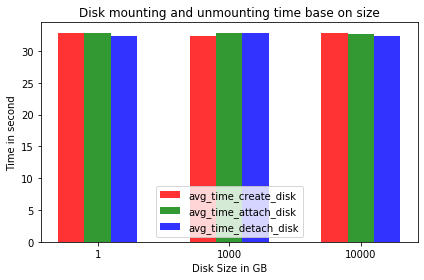

All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-41735647


In [6]:
test_disk_mounting_and_unmounting_base_on_disk_size()

In [16]:
'''
Test2 : Can we mount a disk to multiple VMs as the same time?

Result: No

'''
def test_disk_mounting_under_multiple_vm():
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        
        # create two VM under the same nic and mount the same disk under them
        #create_nic(group_name, network_client, nic_name = NIC_NAME, vnet_name = VNET_NAME, subnet_name = SUBNET_NAME):
        nic1 = create_nic(group_name, network_client, nic_name = "nic1",vnet_name = "vnet1", subnet_name = "subnet1")
        nic2 = create_nic(group_name, network_client, nic_name = "nic2",vnet_name = "vnet2", subnet_name = "subnet2")
        
        virtual_machine1 = vm_create(group_name, "vm1", compute_client, nic1)
        virtual_machine2 = vm_create(group_name, "vm2", compute_client, nic2)
        
        data_disk = disk_create(group_name, "disk1", 100)
        disk_attach(group_name, virtual_machine1, data_disk)
        disk_attach(group_name, virtual_machine2, data_disk)
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)

In [17]:
test_disk_mounting_under_multiple_vm()


Create Resource Group samza-azure-storage-48489271

Create Vnet

Create Subnet

Create NIC

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name

Creating Linux Virtual Machine

Get Virtual Machine by Name
A VM operation failed:
Traceback (most recent call last):
  File "<ipython-input-16-93ada938e2d4>", line 26, in test_disk_mounting_under_multiple_vm
    disk_attach(group_name, virtual_machine2, data_disk)
  File "<ipython-input-15-88c3c558de7b>", line 162, in disk_attach
    virtual_machine
  File "/usr/local/lib/python3.7/site-packages/azure/mgmt/compute/v2019_03_01/operations/virtual_machines_operations.py", line 298, in create_or_update
    **operation_config
  File "/usr/local/lib/python3.7/site-packages/azure/mgmt/compute/v2019_03_01/operations/virtual_machines_operations.py", line 252, in _create_or_update_initial
    raise exp
msrestazure.azure_exceptions.CloudError: Azure Error: ConflictingUserInput
Message: Disk '/subscription

In [20]:
'''
Test3 : Can we mount a disk to one VM and then unmount this disk. Then mount the same disk to another VM? 

Result: No


'''
def test_disk_mounting_to_a_different_vm():
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        
        # create two VM under the same nic and mount the same disk under them
        #create_nic(group_name, network_client, nic_name = NIC_NAME, vnet_name = VNET_NAME, subnet_name = SUBNET_NAME):
        nic1 = create_nic(group_name, network_client, nic_name = "nic1",vnet_name = "vnet1", subnet_name = "subnet1")
        nic2 = create_nic(group_name, network_client, nic_name = "nic2",vnet_name = "vnet2", subnet_name = "subnet2")
        
        virtual_machine1 = vm_create(group_name, "vm1", compute_client, nic1)
        virtual_machine2 = vm_create(group_name, "vm2", compute_client, nic2)
        
        disk_name = "disk1"
        data_disk = disk_create(group_name, disk_name, 100)
        disk_attach(group_name, virtual_machine1, data_disk)
        
        disk_detach(group_name, virtual_machine1, data_disk)
        
        time.sleep(60)
        
        disk_attach(group_name, virtual_machine2, data_disk)
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)

In [21]:
test_disk_mounting_to_a_different_vm()


Create Resource Group samza-azure-storage-58669803

Create Vnet

Create Subnet

Create NIC

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name

Creating Linux Virtual Machine

Get Virtual Machine by Name
A VM operation failed:
Traceback (most recent call last):
  File "<ipython-input-20-0c0525dbcec4>", line 30, in test_disk_mounting_to_a_different_vm
    disk_attach(group_name, virtual_machine2, data_disk)
  File "<ipython-input-15-88c3c558de7b>", line 162, in disk_attach
    virtual_machine
  File "/usr/local/lib/python3.7/site-packages/azure/mgmt/compute/v2019_03_01/operations/virtual_machines_operations.py", line 298, in create_or_update
    **operation_config
  File "/usr/local/lib/python3.7/site-packages/azure/mgmt/compute/v2019_03_01/operations/virtual_machines_operations.py", line 252, in _create_or_update_initial
    raise exp
msrestazure.azure_exceptions.CloudError: Azure Error: ConflictingUserInput
Message: Disk '/subscription

In [22]:
'''
Test4 : Can we mount a disk to one VM and then delete that VM, and then mount this disk to another VM

Result: Yes. 

Comment: If a VM suddently go down, we can mount this disk to another VM

'''
def test_disk_remounting_to_different_vm():
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        
        # create two VM under the same nic and mount the same disk under them
        nic1 = create_nic(group_name, network_client, nic_name = "nic1",vnet_name = "vnet1", subnet_name = "subnet1")
        nic2 = create_nic(group_name, network_client, nic_name = "nic2",vnet_name = "vnet2", subnet_name = "subnet2")
        
        virtual_machine1 = vm_create(group_name, "vm1", compute_client, nic1)
        virtual_machine2 = vm_create(group_name, "vm2", compute_client, nic2)
        
        disk_name = "disk1"
        data_disk = disk_create(group_name, disk_name, 100)
        disk_attach(group_name, virtual_machine1, data_disk)
        
        async_vm_delete = compute_client.virtual_machines.delete(group_name, "vm1")
        async_vm_delete.wait()
        
        time.sleep(60)
        
        disk_attach(group_name, virtual_machine2, data_disk)
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)

In [23]:
test_disk_remounting_to_different_vm()


Create Resource Group samza-azure-storage-60832962

Create Vnet

Create Subnet

Create NIC

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name

Creating Linux Virtual Machine

Get Virtual Machine by Name
All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-60832962


In [24]:
'''
Test5 : 
  1. attach disk1 to vm1
  2. detach disk1
  3. deallocate vm1
  4. attach dis2 to vm2

Result: No

Comment: It seems like that once a disk is attached to a VM, we could not attach it to another VM unless we delete the 
previous VM
    
'''
def test_disk_remounting_to_different_vm2():
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        
        # create two VM under the same nic and mount the same disk under them
        nic1 = create_nic(group_name, network_client, nic_name = "nic1",vnet_name = "vnet1", subnet_name = "subnet1")
        nic2 = create_nic(group_name, network_client, nic_name = "nic2",vnet_name = "vnet2", subnet_name = "subnet2")
        
        virtual_machine1 = vm_create(group_name, "vm1", compute_client, nic1)
        virtual_machine2 = vm_create(group_name, "vm2", compute_client, nic2)
        
        disk_name = "disk1"
        data_disk = disk_create(group_name, disk_name, 100)
        disk_attach(group_name, virtual_machine1, data_disk)
        disk_detach(group_name, virtual_machine1, data_disk)
        
        print('\nDeallocating the VM ')
        async_vm_deallocate = compute_client.virtual_machines.deallocate(group_name, "vm1")
        async_vm_deallocate.wait()
        
        disk_attach(group_name, virtual_machine2, data_disk)
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)

In [25]:
test_disk_remounting_to_different_vm2()


Create Resource Group samza-azure-storage-83953161

Create Vnet

Create Subnet

Create NIC

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name

Creating Linux Virtual Machine

Get Virtual Machine by Name

Deallocating the VM (to prepare for a disk resize)
A VM operation failed:
Traceback (most recent call last):
  File "<ipython-input-24-f144c6716bb4>", line 35, in test_disk_remounting_to_different_vm2
    disk_attach(group_name, virtual_machine2, data_disk)
  File "<ipython-input-15-88c3c558de7b>", line 162, in disk_attach
    virtual_machine
  File "/usr/local/lib/python3.7/site-packages/azure/mgmt/compute/v2019_03_01/operations/virtual_machines_operations.py", line 298, in create_or_update
    **operation_config
  File "/usr/local/lib/python3.7/site-packages/azure/mgmt/compute/v2019_03_01/operations/virtual_machines_operations.py", line 252, in _create_or_update_initial
    raise exp
msrestazure.azure_exceptions.CloudError: Azure Err

In [31]:
'''
Test6 : Test the mount-movement latency. This time include VM delete time and remount time

Result: 


'''
def test_disk_remounting_delay(test_disk_size_list = [1, 1000, 10000]):
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    
    try:
        # create two VM under the same nic and mount the same disk under them
        nic2 = create_nic(group_name, network_client, nic_name = "nic2",vnet_name = "vnet2", subnet_name = "subnet2")
        virtual_machine2 = vm_create(group_name, "vm2", compute_client, nic2)
        REPEAT_TIMES = 3
        mount_movement_time = []
        for size in test_disk_size_list:
            total_mount_movement_time = 0
            for i in range(REPEAT_TIMES):
                disk_name = "disk-{}-{}".format(size, i)
                vm1_name = "vm1-{}-{}".format(size, i)
                nic_name1 = "nic1-{}-{}".format(size, i)
                vnet_name1 = "vnet1-{}-{}".format(size, i)
                subnet_name1 = "subnet1-{}-{}".format(size, i)
                nic1 = create_nic(group_name, network_client, nic_name = nic_name1, 
                                  vnet_name = vnet_name1, subnet_name = subnet_name1)
                virtual_machine1 = vm_create(group_name, vm1_name, compute_client, nic1)
                data_disk = disk_create(group_name, disk_name, size)
                disk_attach(group_name, virtual_machine1, data_disk)
                #start to test mount-movement time
                start = time.time()
                async_vm_delete = compute_client.virtual_machines.delete(group_name, vm1_name)
                async_vm_delete.wait()
                disk_attach(group_name, virtual_machine2, data_disk)
                total_mount_movement_time += (time.time() - start)
            mount_movement_time.append(total_mount_movement_time / REPEAT_TIMES)
            
        #plot the result
        # data to plot
        n_groups = len(test_disk_size_list)

        # create plot
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.2
        opacity = 0.8

        rects1 = plt.bar(index, mount_movement_time, bar_width,
        alpha=opacity,
        color='r',
        label='avg_time_mount_movement')

        plt.xlabel('Disk Size in GB')
        plt.ylabel('Time in second')
        plt.title('Disk mount-movement delay base on size')
        plt.xticks(index + bar_width, test_disk_size_list)
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)

In [ ]:
test_disk_remounting_to_different_vm()


Create Resource Group samza-azure-storage-6834332

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name

Create Vnet

Create Subnet

Create NIC
